In [20]:
## Data processing packages
import numpy as np
import pandas as pd
import datetime
from geopy.distance import geodesic
## Modeling packages
import sklearn
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
## Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Model explanation
import eli5

In [2]:
df = pd.read_csv('flight_delays_data.csv')

In [3]:
df

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0
...,...,...,...,...,...,...,...,...,...,...
899109,2793494,BA7408,22,HKG,BNE,BA,20,0.2,2014-05-29,0
899110,2793495,CA6506,35,HKG,CKG,CA,13,1.0,2015-08-30,0
899111,2793502,CX464,42,HKG,TPE,CX,19,0.6,2015-10-20,0
899112,2793514,AA8902,1,HKG,SIN,AA,20,0.1,2015-01-01,0


In [4]:
# Create label variable
df.loc[df['is_claim'] == 0, 'label'] = 0
df['label'] = df['label'].fillna(1)
df

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,label
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,0.0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,0.0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,0.0
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0,0.0
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
899109,2793494,BA7408,22,HKG,BNE,BA,20,0.2,2014-05-29,0,0.0
899110,2793495,CA6506,35,HKG,CKG,CA,13,1.0,2015-08-30,0,0.0
899111,2793502,CX464,42,HKG,TPE,CX,19,0.6,2015-10-20,0,0.0
899112,2793514,AA8902,1,HKG,SIN,AA,20,0.1,2015-01-01,0,0.0


In [5]:
# Create time features
def get_weekday(string):
    year, month, day = (int(i) for i in string.split('-'))
    dt = datetime.date(year, month, day)
    return dt.strftime("%A")

In [6]:
df['weekday'] = df['flight_date'].apply(lambda date: get_weekday(date))
df

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,label,weekday
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,0.0,Friday
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,0.0,Thursday
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,0.0,Tuesday
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0,0.0,Sunday
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0,0.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
899109,2793494,BA7408,22,HKG,BNE,BA,20,0.2,2014-05-29,0,0.0,Thursday
899110,2793495,CA6506,35,HKG,CKG,CA,13,1.0,2015-08-30,0,0.0,Sunday
899111,2793502,CX464,42,HKG,TPE,CX,19,0.6,2015-10-20,0,0.0,Tuesday
899112,2793514,AA8902,1,HKG,SIN,AA,20,0.1,2015-01-01,0,0.0,Thursday


In [7]:
# Create new variable for airline
df.groupby('Airline').mean().label.sort_values(ascending = False).head(20)

Airline
BO    1.000000
HB    1.000000
P7    1.000000
O3    0.909091
SV    0.750000
BG    0.747253
E8    0.331507
O8    0.326787
PK    0.291667
LV    0.275449
MF    0.264013
OX    0.263194
2P    0.262295
HO    0.246324
9C    0.172478
CZ    0.151007
ZH    0.150672
RA    0.140230
MU    0.134208
PQ    0.130435
Name: label, dtype: float64

In [8]:
df.groupby('Airline').mean().label.sort_values(ascending = False).tail(20)

Airline
SQ    0.008560
VA    0.007430
GK    0.006211
B6    0.006126
JU    0.005556
HG    0.004662
AB    0.004662
XF    0.000000
VQ    0.000000
TV    0.000000
3V    0.000000
HZ    0.000000
QG    0.000000
SO    0.000000
JD    0.000000
JT    0.000000
B5    0.000000
Y8    0.000000
NQ    0.000000
TT    0.000000
Name: label, dtype: float64

In [9]:
highest_delay = ['BO', 'HB', 'P7']
high_delay = ['O3', 'SV', 'BG']
medium_delay = ['E8', 'O8', 'PK', 'LV', 'MF', 'OX', '2P', 'HO']
lowest_delay = ['XF', 'VQ', 'TV', '3V', 'HZ', 'QG', 'SO', 'JD', 'JT', 'B5', 'Y8', 'NQ', 'TT']

In [10]:
df.loc[df['Airline'].isin(highest_delay), 'airline_grp'] = 'highest_delay'
df.loc[df['Airline'].isin(high_delay), 'airline_grp'] = 'high_delay'
df.loc[df['Airline'].isin(medium_delay), 'airline_grp'] = 'medium_delay'
df.loc[df['Airline'].isin(lowest_delay), 'airline_grp'] = 'lowest_delay'
df['airline_grp'] = df['airline_grp'].fillna('low_delay')
df

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,label,weekday,airline_grp
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,0.0,Friday,low_delay
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,0.0,Thursday,low_delay
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,0.0,Tuesday,low_delay
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0,0.0,Sunday,low_delay
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0,0.0,Monday,low_delay
...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,2793494,BA7408,22,HKG,BNE,BA,20,0.2,2014-05-29,0,0.0,Thursday,low_delay
899110,2793495,CA6506,35,HKG,CKG,CA,13,1.0,2015-08-30,0,0.0,Sunday,low_delay
899111,2793502,CX464,42,HKG,TPE,CX,19,0.6,2015-10-20,0,0.0,Tuesday,low_delay
899112,2793514,AA8902,1,HKG,SIN,AA,20,0.1,2015-01-01,0,0.0,Thursday,low_delay


In [11]:
# Create new variable for Arrival
arrival_lst = df.groupby('Arrival').mean().label.sort_values(ascending = False)

In [12]:
high_delay_arrival = arrival_lst.head(10).index.values.tolist()
medium_delay_arrival = arrival_lst[10:23].index.values.tolist()

In [13]:
df.loc[df['Arrival'].isin(high_delay_arrival), 'arrival_grp'] = 'high_delay'
df.loc[df['Arrival'].isin(medium_delay_arrival), 'arrival_grp'] = 'medium_delay'
df['arrival_grp'] = df['arrival_grp'].fillna('low_delay')
df

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,label,weekday,airline_grp,arrival_grp
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,0.0,Friday,low_delay,low_delay
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,0.0,Thursday,low_delay,medium_delay
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,0.0,Tuesday,low_delay,low_delay
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0,0.0,Sunday,low_delay,low_delay
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0,0.0,Monday,low_delay,low_delay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,2793494,BA7408,22,HKG,BNE,BA,20,0.2,2014-05-29,0,0.0,Thursday,low_delay,low_delay
899110,2793495,CA6506,35,HKG,CKG,CA,13,1.0,2015-08-30,0,0.0,Sunday,low_delay,low_delay
899111,2793502,CX464,42,HKG,TPE,CX,19,0.6,2015-10-20,0,0.0,Tuesday,low_delay,low_delay
899112,2793514,AA8902,1,HKG,SIN,AA,20,0.1,2015-01-01,0,0.0,Thursday,low_delay,low_delay


In [14]:
# Create new variable for distance
airports = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", header = None)

In [15]:
airports.set_axis(['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6',
                  'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13'], axis=1, inplace=True)

In [16]:
airports

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports
7695,14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports


In [17]:
start = (airports[airports['v4'] == 'HKG'].v6.values[0], airports[airports['v4'] == 'HKG'].v7.values[0])
start

(22.308901000000002, 113.915001)

In [18]:
def get_distance(airport):
    target = (airports[airports['v4'] == airport].v6.values[0], airports[airports['v4'] == airport].v7.values[0])
    return geodesic(start, target).miles

In [19]:
df['distance'] = df['Arrival'].apply(lambda airport: get_distance(airport))
df

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,label,weekday,airline_grp,arrival_grp,distance
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,0.0,Friday,low_delay,low_delay,1538.819066
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,0.0,Thursday,low_delay,medium_delay,404.234532
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,0.0,Tuesday,low_delay,low_delay,710.584178
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0,0.0,Sunday,low_delay,low_delay,1587.883184
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0,0.0,Monday,low_delay,low_delay,1234.357238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,2793494,BA7408,22,HKG,BNE,BA,20,0.2,2014-05-29,0,0.0,Thursday,low_delay,low_delay,4305.850141
899110,2793495,CA6506,35,HKG,CKG,CA,13,1.0,2015-08-30,0,0.0,Sunday,low_delay,low_delay,681.440835
899111,2793502,CX464,42,HKG,TPE,CX,19,0.6,2015-10-20,0,0.0,Tuesday,low_delay,low_delay,501.280550
899112,2793514,AA8902,1,HKG,SIN,AA,20,0.1,2015-01-01,0,0.0,Thursday,low_delay,low_delay,1587.883184


In [2]:
## Export for future use
### df.to_csv('dataframe.csv', index = False)
### df = pd.read_csv('dataframe.csv')
### df

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,label,weekday,airline_grp,arrival_grp,distance
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,0.0,Friday,low_delay,low_delay,1538.819066
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,0.0,Thursday,low_delay,medium_delay,404.234532
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,0.0,Tuesday,low_delay,low_delay,710.584178
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0,0.0,Sunday,low_delay,low_delay,1587.883184
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0,0.0,Monday,low_delay,low_delay,1234.357238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,2793494,BA7408,22,HKG,BNE,BA,20,0.2,2014-05-29,0,0.0,Thursday,low_delay,low_delay,4305.850141
899110,2793495,CA6506,35,HKG,CKG,CA,13,1.0,2015-08-30,0,0.0,Sunday,low_delay,low_delay,681.440835
899111,2793502,CX464,42,HKG,TPE,CX,19,0.6,2015-10-20,0,0.0,Tuesday,low_delay,low_delay,501.280550
899112,2793514,AA8902,1,HKG,SIN,AA,20,0.1,2015-01-01,0,0.0,Thursday,low_delay,low_delay,1587.883184


In [3]:
# Select and process the variables for modeling
df_model = df[['label', 'std_hour', 'weekday', 'Week',
               'airline_grp', 'arrival_grp', 'distance']]
df_model

,label,std_hour,weekday,Week,airline_grp,arrival_grp,distance
0,0.0,10,Friday,27,low_delay,low_delay,1538.819066
1,0.0,11,Thursday,17,low_delay,medium_delay,404.234532
2,0.0,11,Tuesday,14,low_delay,low_delay,710.584178
3,0.0,3,Sunday,37,low_delay,low_delay,1587.883184
4,0.0,9,Monday,40,low_delay,low_delay,1234.357238
...,...,...,...,...,...,...,...
899109,0.0,20,Thursday,22,low_delay,low_delay,4305.850141
899110,0.0,13,Sunday,35,low_delay,low_delay,681.440835
899111,0.0,19,Tuesday,42,low_delay,low_delay,501.280550
899112,0.0,20,Thursday,1,low_delay,low_delay,1587.883184


In [4]:
hour_df = pd.get_dummies(df_model['std_hour'], prefix='hour', drop_first=True)
df_model = pd.concat([df_model, hour_df], axis=1)
df_model.drop(['std_hour'], axis=1, inplace=True)
df_model

,label,weekday,Week,airline_grp,arrival_grp,distance,hour_1,hour_2,hour_3,hour_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.0,Friday,27,low_delay,low_delay,1538.819066,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,Thursday,17,low_delay,medium_delay,404.234532,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,Tuesday,14,low_delay,low_delay,710.584178,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,Sunday,37,low_delay,low_delay,1587.883184,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,Monday,40,low_delay,low_delay,1234.357238,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,0.0,Thursday,22,low_delay,low_delay,4305.850141,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
899110,0.0,Sunday,35,low_delay,low_delay,681.440835,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
899111,0.0,Tuesday,42,low_delay,low_delay,501.280550,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
899112,0.0,Thursday,1,low_delay,low_delay,1587.883184,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
weekday_df = pd.get_dummies(df_model['weekday'], prefix='weekday', drop_first=True)
df_model = pd.concat([df_model, weekday_df], axis=1)
df_model.drop(['weekday'], axis=1, inplace=True)
df_model

,label,Week,airline_grp,arrival_grp,distance,hour_1,hour_2,hour_3,hour_4,hour_5,...,hour_20,hour_21,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.0,27,low_delay,low_delay,1538.819066,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,17,low_delay,medium_delay,404.234532,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,14,low_delay,low_delay,710.584178,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,37,low_delay,low_delay,1587.883184,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0.0,40,low_delay,low_delay,1234.357238,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,0.0,22,low_delay,low_delay,4305.850141,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
899110,0.0,35,low_delay,low_delay,681.440835,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
899111,0.0,42,low_delay,low_delay,501.280550,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
899112,0.0,1,low_delay,low_delay,1587.883184,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [6]:
week_df = pd.get_dummies(df_model['Week'], prefix='week', drop_first=True)
df_model = pd.concat([df_model, week_df], axis=1)
df_model.drop(['Week'], axis=1, inplace=True)
df_model

,label,airline_grp,arrival_grp,distance,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,0.0,low_delay,low_delay,1538.819066,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,low_delay,medium_delay,404.234532,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,low_delay,low_delay,710.584178,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,low_delay,low_delay,1587.883184,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,low_delay,low_delay,1234.357238,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,0.0,low_delay,low_delay,4305.850141,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
899110,0.0,low_delay,low_delay,681.440835,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
899111,0.0,low_delay,low_delay,501.280550,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
899112,0.0,low_delay,low_delay,1587.883184,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
airline_grp_df = pd.get_dummies(df_model['airline_grp'], prefix='airline', drop_first=True)
df_model = pd.concat([df_model, airline_grp_df], axis=1)
df_model.drop(['airline_grp'], axis=1, inplace=True)
df_model

,label,arrival_grp,distance,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,week_47,week_48,week_49,week_50,week_51,week_52,airline_highest_delay,airline_low_delay,airline_lowest_delay,airline_medium_delay
0,0.0,low_delay,1538.819066,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,medium_delay,404.234532,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,low_delay,710.584178,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.0,low_delay,1587.883184,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,low_delay,1234.357238,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,0.0,low_delay,4305.850141,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
899110,0.0,low_delay,681.440835,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
899111,0.0,low_delay,501.280550,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
899112,0.0,low_delay,1587.883184,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
arrival_grp_df = pd.get_dummies(df_model['arrival_grp'], prefix='arrival', drop_first=True)
df_model = pd.concat([df_model, arrival_grp_df], axis=1)
df_model.drop(['arrival_grp'], axis=1, inplace=True)
df_model

,label,distance,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,week_49,week_50,week_51,week_52,airline_highest_delay,airline_low_delay,airline_lowest_delay,airline_medium_delay,arrival_low_delay,arrival_medium_delay
0,0.0,1538.819066,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0.0,404.234532,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0.0,710.584178,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0.0,1587.883184,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1234.357238,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,0.0,4305.850141,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
899110,0.0,681.440835,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
899111,0.0,501.280550,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
899112,0.0,1587.883184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [9]:
# Modeling
X = df_model.iloc[:,1:]
X

,distance,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,week_49,week_50,week_51,week_52,airline_highest_delay,airline_low_delay,airline_lowest_delay,airline_medium_delay,arrival_low_delay,arrival_medium_delay
0,1538.819066,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,404.234532,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,710.584178,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1587.883184,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,1234.357238,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899109,4305.850141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
899110,681.440835,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
899111,501.280550,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
899112,1587.883184,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [10]:
y = df_model.iloc[:,0]
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
899109    0.0
899110    0.0
899111    0.0
899112    0.0
899113    0.0
Name: label, Length: 899114, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)

In [12]:
def model_result(model):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print('\nTRAIN RESULTS:')
    print("Accuracy:", accuracy_score(y_train, train_pred))
    print("AUC-ROC:", roc_auc_score(y_train, train_pred))
    print('\nTEST RESULTS:')
    print("Accuracy:", accuracy_score(y_test, test_pred))
    print("AUC-ROC:", roc_auc_score(y_test, test_pred))

In [13]:
## Baseline model
clf_baseline = LogisticRegression(max_iter=10000)
clf_baseline.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [14]:
model_result(clf_baseline)


TRAIN RESULTS:
Accuracy: 0.9561647274535693
AUC-ROC: 0.5

TEST RESULTS:
Accuracy: 0.9561643835616438
AUC-ROC: 0.5


In [13]:
## SMOTE sampling 
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [17]:
## Logistic regression
clf_logistic = LogisticRegression(max_iter=10000)
clf_logistic.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [18]:
model_result(clf_logistic)


TRAIN RESULTS:
Accuracy: 0.7047641203742169
AUC-ROC: 0.587518071087921

TEST RESULTS:
Accuracy: 0.9069568279978497
AUC-ROC: 0.5817559158004117


In [14]:
## Random forest
clf_rf = RandomForestClassifier(n_estimators=500, random_state = 123)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=123)

In [15]:
model_result(clf_rf)


TRAIN RESULTS:
Accuracy: 0.9408763854500739
AUC-ROC: 0.9398710513634324

TEST RESULTS:
Accuracy: 0.8675996811685543
AUC-ROC: 0.7615040895890443


In [44]:
## LightGBM
clf_lgbm = LGBMClassifier(random_state=123, n_estimators=500)
clf_lgbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=500, random_state=123)

In [45]:
model_result(clf_lgbm)


TRAIN RESULTS:
Accuracy: 0.8421930130665736
AUC-ROC: 0.8029462104720917

TEST RESULTS:
Accuracy: 0.893658590839157
AUC-ROC: 0.6968553347860308


In [49]:
## XGBoosting
clf_xgb = XGBClassifier(random_state=123, n_estimators=500)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [50]:
model_result(clf_xgb)


TRAIN RESULTS:
Accuracy: 0.8709184266936971
AUC-ROC: 0.8455358181425414

TEST RESULTS:
Accuracy: 0.8909707676052422
AUC-ROC: 0.7187307346332649


In [85]:
## ROC plots
classifiers = [clf_baseline,
              clf_logistic,
              clf_rf,
              clf_lgbm,
              clf_xgb]
clf_names = ['clf_baseline',
              'clf_logistic',
              'clf_rf',
              'clf_lgbm',
              'clf_xgb']

In [86]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc-roc'])

In [88]:
for i in range(len(classifiers)):
    
    clf = classifiers[i]
    
    yproba = clf.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':clf_names[i],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc-roc':auc}, ignore_index=True)

In [89]:
result_table

,classifiers,fpr,tpr,auc-roc
0,clf_baseline,"[0.0, 3.877306512711749e-06, 2.326383907627049...","[0.0, 0.0, 0.0, 8.457374830852504e-05, 8.45737...",0.655897
1,clf_logistic,"[0.0, 3.877306512711749e-06, 2.326383907627049...","[0.0, 0.0, 0.0, 0.00016914749661705008, 0.0001...",0.674526
2,clf_rf,"[0.0, 0.005633726362970172, 0.0056414809759955...","[0.0, 0.049137347767253044, 0.0492219215155615...",0.861835
3,clf_lgbm,"[0.0, 0.0, 0.0, 1.1631919538135249e-05, 1.1631...","[0.0, 8.457374830852504e-05, 0.000507442489851...",0.827983
4,clf_xgb,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.877306512711749e-0...","[0.0, 8.457374830852504e-05, 0.001014884979702...",0.846874


In [90]:
result_table.set_index('classifiers', inplace=True)

In [91]:
result_table

,fpr,tpr,auc-roc
classifiers,,,
clf_baseline,"[0.0, 3.877306512711749e-06, 2.326383907627049...","[0.0, 0.0, 0.0, 8.457374830852504e-05, 8.45737...",0.655897
clf_logistic,"[0.0, 3.877306512711749e-06, 2.326383907627049...","[0.0, 0.0, 0.0, 0.00016914749661705008, 0.0001...",0.674526
clf_rf,"[0.0, 0.005633726362970172, 0.0056414809759955...","[0.0, 0.049137347767253044, 0.0492219215155615...",0.861835
clf_lgbm,"[0.0, 0.0, 0.0, 1.1631919538135249e-05, 1.1631...","[0.0, 8.457374830852504e-05, 0.000507442489851...",0.827983
clf_xgb,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.877306512711749e-0...","[0.0, 8.457374830852504e-05, 0.001014884979702...",0.846874


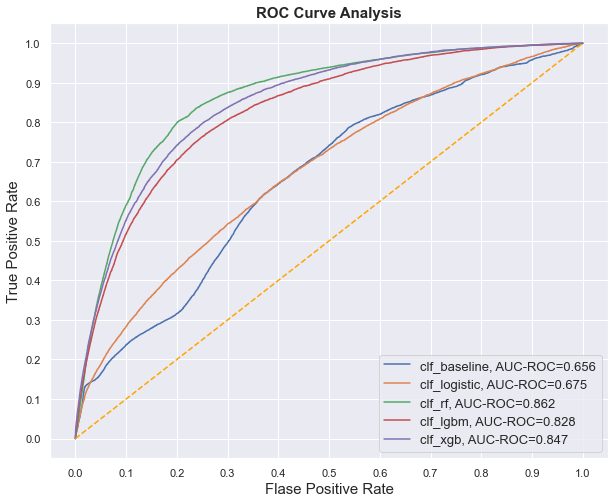

In [94]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC-ROC={:.3f}".format(i, result_table.loc[i]['auc-roc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [19]:
## Final model analysis
eli5.show_weights(clf_rf, top = 20, feature_names = X_train.columns.to_list())

Weight,Feature
0.3177 ± 0.0819,distance
0.0234 ± 0.0055,weekday_Tuesday
0.0223 ± 0.0053,weekday_Wednesday
0.0221 ± 0.0072,weekday_Sunday
0.0216 ± 0.0072,weekday_Monday
0.0189 ± 0.0177,arrival_low_delay
0.0182 ± 0.0104,weekday_Saturday
0.0168 ± 0.0109,weekday_Thursday
0.0148 ± 0.0080,week_4
0.0140 ± 0.0221,airline_low_delay


In [21]:
## Calculate errors for testing
test_proba = clf_rf.predict_proba(X_test)[::,1]
test_proba

array([0.31992392, 0.04075814, 0.04154444, ..., 0.00583333, 0.02475952,
       0.98184499])

In [27]:
actual_claim = 800*y_test.values
actual_claim

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
pred_claim = 800*test_proba
pred_claim

array([255.9391342 ,  32.60651349,  33.23555556, ...,   4.66666667,
        19.80761905, 785.47599453])

In [33]:
def get_mae(pred, actual):
    res = [abs(i - j) for i, j in zip(pred, actual)]
    return sum(res)/len(pred)

In [34]:
def get_brier_error(pred, actual):
    res = [(i - j)**2 for i, j in zip(pred, actual)]
    return sum(res)/len(pred)

In [35]:
get_mae(test_proba, actual_claim)

35.21178885709525

In [36]:
get_brier_error(test_proba, actual_claim)

28011.43678950288